In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, v_measure_score, homogeneity_completeness_v_measure, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

Исходный файл отсюда: https://www.openml.org/d/554

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X = X.values

In [162]:
def plot_digits(X_, y_,nrows=1, ncols=10, size=(15,5)):
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)
    for ax, image, label in zip(axes.flatten(), X_, y_):
        ax.set_axis_off()
        ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)
        ax.set_title(f'cluster # {label}')

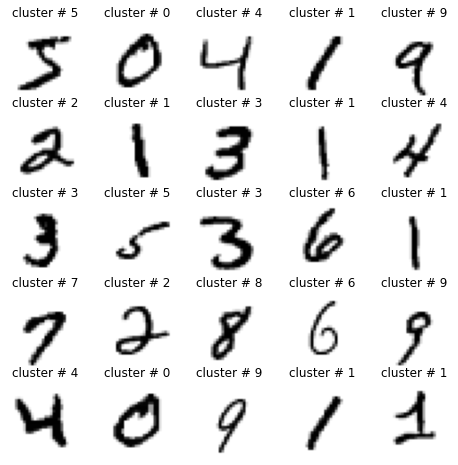

In [163]:
plot_digits(X[0:25],y[0:25], nrows=5, ncols=5, size=(8, 8))

In [164]:
X.shape

(70000, 784)

Так как датасет очень большой, воспользуемся функцией MiniBatchKMeans вместо обычного KMeans.

In [165]:
n_digits = len(np.unique(y))
print(n_digits)

kmeans_pred = MiniBatchKMeans(init="k-means++", n_clusters=10, n_init=100, random_state=0).fit_predict(X)

10


C:\Users\apple\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [166]:
kmeans_pred

array([1, 4, 2, ..., 3, 2, 6])

In [168]:
def cluster_centers(X_, pred_labels_):
    clusters_num = []
    clusters_mean = []
    for i in np.unique(pred_labels_):
        clusters_num.append(i)
        cluster_index = np.argwhere(pred_labels_ == i)
        cluster = X_[cluster_index.flatten()]
        cluster_mean = np.mean(cluster, axis=0)
        clusters_mean.append(cluster_mean)
    return clusters_num, clusters_mean

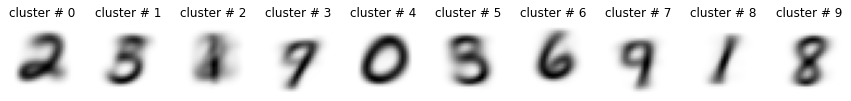

In [170]:
clusters_nums_k, clusters_centers_k = cluster_centers(X, kmeans_pred)
plot_digits(clusters_centers_k, clusters_nums_k)

Так как многие цифры имеют много вариаций написания, алгоритм плохо справляется с разбиением на 10 кластеров. Поэтому можно поступить следующим образом: попробуем разбить наблюдения на большое количество кластеров (например, на 100), подразумевая, что различные написания каждой цифры будту определяться в разные кластеры. Затем воспользуемся тем, что у нас имеется правильное разбиение. Каждому предсказанному из 100 кластеров присвоим новую метку от 0 до 9, основываясь на том, какая истинная метка чаще встречается в данном кластере.

In [171]:
kmeans_pred = MiniBatchKMeans(init="k-means++", n_clusters=100, n_init=100, random_state=0).fit_predict(X)

C:\Users\apple\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [172]:
kmeans_pred

array([78, 23,  2, ..., 25, 60, 80])

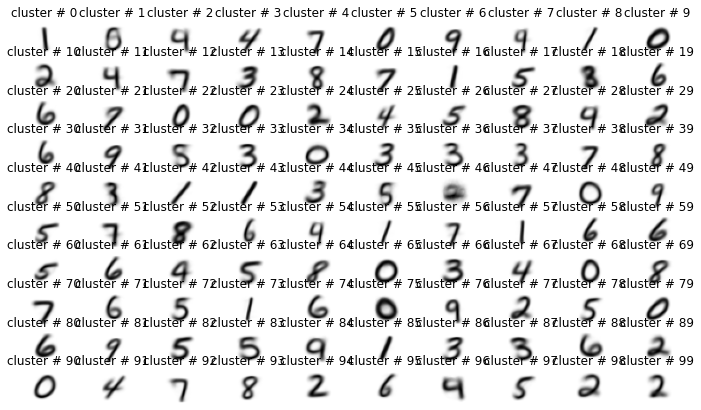

In [174]:
clusters_nums_k_100, clusters_centers_k_100 = cluster_centers(X, kmeans_pred)
plot_digits(clusters_centers_k_100, clusters_nums_k_100, nrows=10, ncols=10, size=(12, 7))

In [150]:
#silhouette_score(X, kmeans.labels_)

In [175]:
print('V measure при 100 кластерах: ', v_measure_score(y, kmeans_pred))

V measure при 100 кластерах:  0.5221177230222929


In [176]:
# присваиваем новые метки
indexes = []
new_predict = np.zeros(len(kmeans_pred))
for c in np.unique(kmeans_pred):
    index = np.argwhere(kmeans_pred == c)
    true_pred = y[index.flatten()]
    counts_true = np.unique(true_pred, return_counts=True)
    most_label = counts_true[0][np.argmax(counts_true[1])]
    new_predict[index] = most_label

In [177]:
np.unique(new_predict)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [178]:
#silhouette_score(X, new_predict)

In [179]:
print('V measure после переопределения до 10 кластеров: ', v_measure_score(y, new_predict))

V measure после переопределения до 10 кластеров:  0.7363638514313412


Видно, что такой подход позволил значительно увеличить V measure.

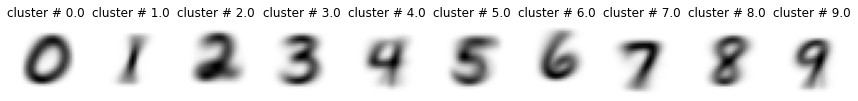

In [180]:
clusters_nums_k_10, clusters_centers_k_10 = cluster_centers(X, new_predict)
plot_digits(clusters_centers_k_10, clusters_nums_k_10)

При этом также неплохо распознались, но есть некоторые проблемы с 4й.

В предыдущих заданиях хорошие результаты получались после снижения размерности методом tSNE. Но так как данный датасет достаточно большой, будет использовать аналогичный метод UMAP. Установка: https://github.com/lmcinnes/umap (через conda)

In [181]:
import umap

In [182]:
X_embedded = umap.UMAP().fit_transform(X)

In [183]:
X_embedded

array([[ 5.95221  ,  8.1672735],
       [15.506428 ,  7.1832743],
       [ 0.7174104, 14.887006 ],
       ...,
       [-2.0930276, 14.177797 ],
       [ 4.3685784, 10.038896 ],
       [11.490743 ,  3.938069 ]], dtype=float32)

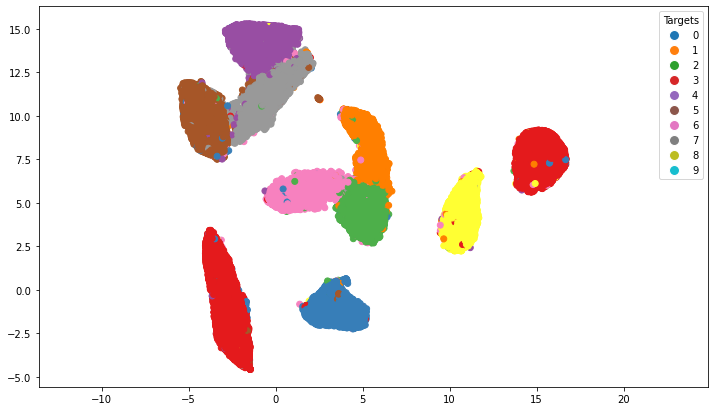

In [184]:
plt.figure(figsize=(12, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=plt.cm.Set1(y / 10.))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=colors_[i][0], markersize=10, color='w', label = i) 
                   for i in range(0,len(colors_))]

plt.legend(handles=legend_elements, title='Targets')
plt.axis('equal')
plt.show()

In [185]:
kmeans_embedded = MiniBatchKMeans(init="k-means++", n_clusters=100, n_init=100, random_state=0).fit_predict(X_embedded)

C:\Users\apple\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [186]:
kmeans_embedded

array([49, 21, 58, ..., 67, 96, 54])

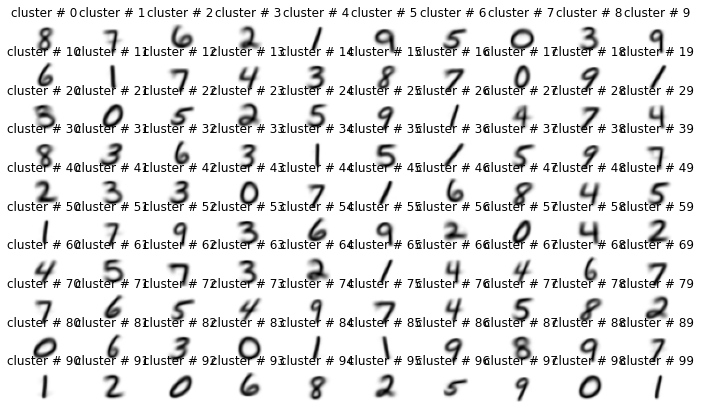

In [191]:
clusters_nums_umap_k_100, clusters_centers_umap_k_100 = cluster_centers(X, kmeans_embedded)
plot_digits(clusters_centers_umap_k_100, clusters_nums_umap_k_100, nrows=10, ncols=10, size=(12, 7))

In [192]:
print('V measure после UMAP при 100 кластерах: ', v_measure_score(y, kmeans_embedded))

V measure после UMAP при 100 кластерах:  0.6174381690539801


In [193]:
indexes = []
new_predict_embedded = np.zeros(len(kmeans_embedded))
for c in np.unique(kmeans_embedded):
    index = np.argwhere(kmeans_embedded == c)
    true_pred = y[index.flatten()]
    counts_true = np.unique(true_pred, return_counts=True)
    most_label = counts_true[0][np.argmax(counts_true[1])]
    new_predict_embedded[index] = most_label

In [194]:
new_predict_embedded

array([5., 0., 4., ..., 4., 5., 6.])

In [195]:
print('V measure после UMAP после переопределения до 10 кластеров: ', v_measure_score(y, new_predict_embedded))

V measure после UMAP после переопределения до 10 кластеров:  0.9143506798906735


In [196]:
#silhouette_score(X, new_predict_embedded)

При таком подходе получилось добиться высокого значения V measure ~0.914. Однако silhouette при этом равен ~0.046 (он долго считается). Поэтому посмотрим на средние значения наших кластеров:

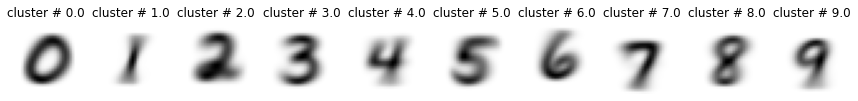

In [197]:
clusters_nums_umap_k_10, clusters_centers_umap_k_10 = cluster_centers(X, new_predict_embedded)
plot_digits(clusters_centers_umap_k_10, clusters_nums_umap_k_10)

Все цифры неплохо распознались, поэтому, можно сделать вывод о том, что метрика silhouette не всегда отражает точность кластеризации.